## Three Stock Monte

This exercise tests your ability to retrieve stock price data using the Alpaca API and simulate multiple portfolio compositions using Monte Carlo Simulation.

### Import Dependencies

In [22]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

import warnings
warnings.filterwarnings('ignore')

In [23]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [24]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Get Past ~4 Year's Worth of Stock Price Data via Alpaca API Call

In [25]:
# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 4 years ago.
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-05-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["T","NKE","XOM"]

# Get 4 year's worth of historical price data
# HINT: Set "limit" to at least 10000 so all ticker rows are captured from get_bars()
df_ticker = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=10000
).df

# Display sample data
df_ticker.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-05-01 04:00:00+00:00,55.43,55.45,54.98,54.99,4881442,30491,55.201737,NKE
2017-05-02 04:00:00+00:00,55.12,55.16,54.79,55.07,7363885,41589,54.967165,NKE
2017-05-03 04:00:00+00:00,55.17,55.30,54.40,54.53,9486619,48477,54.622933,NKE
2017-05-04 04:00:00+00:00,54.68,54.83,54.20,54.47,6830628,39260,54.501544,NKE
2017-05-05 04:00:00+00:00,54.41,54.50,53.56,53.95,13379949,57959,53.889567,NKE


> Note: We're going to simulate five years of growth below, and so we might want to pull at least five years of data in order to do that. But we pulled four because of Alpaca's rate limits--we can only pull 1,000 rows per ticker at a time (approximately four years of data, with 252 tradable days per year). If we pull data with repeated calls in a `for` loop, however, we can get quite a few more years than what we've got above.  

In [26]:
# Reorganize the DataFrame
# Separate ticker data
T = df_ticker[df_ticker["symbol"]=="T"].drop("symbol", axis=1)
NKE = df_ticker[df_ticker["symbol"]=="NKE"].drop("symbol", axis=1)
XOM = df_ticker[df_ticker["symbol"]=="XOM"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([T, NKE, XOM], axis=1, keys=["T","NKE","XOM"])

# Display sample data
df_ticker.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                        NKE                ...            \
                                vwap   open   high    low  ...    volume   
timestamp                                                  ...             
2017-05-01 04:00:00+00:00  39.278779  55.43  55.45  54.98  ...   4881442   
2017-05-02 04:00:00+00:00  38.996448  55.12  55.16  54.79  ...   7363885   
2017-05-03 04:00:00+00:00  38.423685  55.17  55.30  54.40  ...   9486619   
2017-05-04 04:00:00+00:00  37.965109  54.68  54.83  54.20  ...   6830628   
2017-05-05 04:00:00+00:00  38.424403  54.41  54.50  53.56  ...  13379949   

                                                    XOM                  \
                          trade_count       vwap   open     high    low   
timestamp                                                                 
2017-05-01 04:00:00+00:00       30491  55.201737  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00       41589  54.967165  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00       48477  54.622933  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00       39260  54.501544  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00       57959  53.889567  81.63  82.2350  81.61   

                                                                   
                           close    volume trade_count       vwap  
timestamp                                                          
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657  

[5 rows x 21 columns]

### Simulate five year portfolio growth with evenly-distributed stock investments

In [34]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
num_sims = 500

MC_3 = MCSimulation(
    portfolio_data= df_ticker,
    weights=[.33,.33,.33],
    num_simulation= num_sims,
    num_trading_days= 252 * 5
)
# Print the simulation input data
MC_3.portfolio_data.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                                     NKE         ...  \
                                vwap daily_return   open   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  55.43  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.12  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  55.17  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.68  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  54.41  54.50  ...   

                                                     XOM                  \
                                vwap daily_return   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  81.63  82.2350  81.61   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  

[5 rows x 24 columns]

In [35]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
MC_3.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.010960,0.993408,1.009816,1.003535,1.004743,0.989974,0.981103,1.000489,1.000706,1.014516,...,0.998676,0.996658,0.994869,1.005445,1.003266,0.995475,0.988277,1.024507,0.993207,0.991019
2,0.997573,1.012247,0.995396,1.000061,1.001657,0.999077,0.964103,1.014383,1.002325,1.003566,...,1.000153,1.007988,1.003516,1.005287,0.994338,0.983119,1.006274,1.010728,1.001212,1.001614
3,0.991371,1.010137,1.003788,1.016967,0.990134,1.017256,0.949961,1.015817,1.010836,0.990082,...,0.987836,1.006051,0.993421,1.007249,1.013178,0.976408,1.003485,1.011896,1.018875,0.986567
4,0.991571,1.007279,1.009555,1.018415,0.988094,1.031567,0.952240,1.007151,1.010027,0.969232,...,0.994783,1.003554,0.995261,0.995406,1.022222,0.972630,1.003140,1.023103,1.028929,0.998165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.940161,0.991196,1.466041,0.883112,0.848934,1.132742,0.897090,1.056769,2.742738,1.330006,...,0.628321,1.729861,1.306146,1.400691,2.014983,0.740381,1.029322,1.871174,1.564935,1.225549
1257,0.942010,0.998596,1.472203,0.888888,0.857164,1.138841,0.906285,1.076125,2.773109,1.330595,...,0.639841,1.722829,1.272770,1.408958,2.054469,0.738023,1.032297,1.887350,1.560721,1.222484
1258,0.933788,0.997003,1.443351,0.895734,0.846596,1.150215,0.913869,1.061848,2.779563,1.350990,...,0.635369,1.730709,1.263189,1.419816,2.054074,0.734556,1.024152,1.855429,1.560063,1.220330
1259,0.926220,1.000849,1.438251,0.902288,0.850546,1.160412,0.912274,1.045245,2.767559,1.328401,...,0.637655,1.709016,1.260868,1.420641,2.012448,0.746165,1.020013,1.855907,1.571237,1.215341


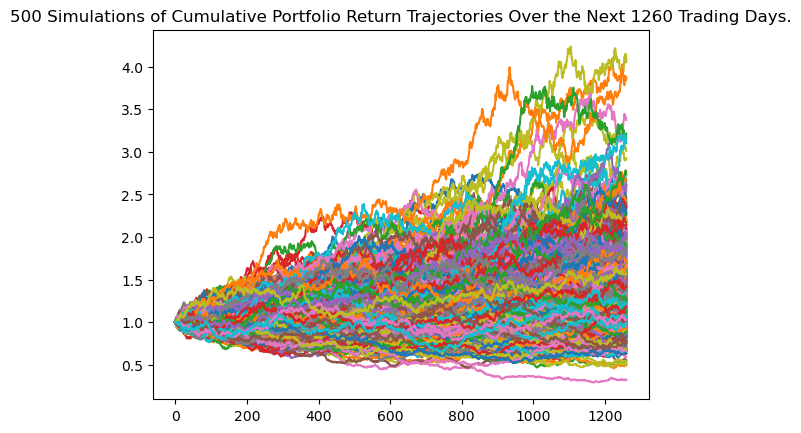

In [36]:
# Plot simulation outcomes
line_plot = MC_3.plot_simulation()

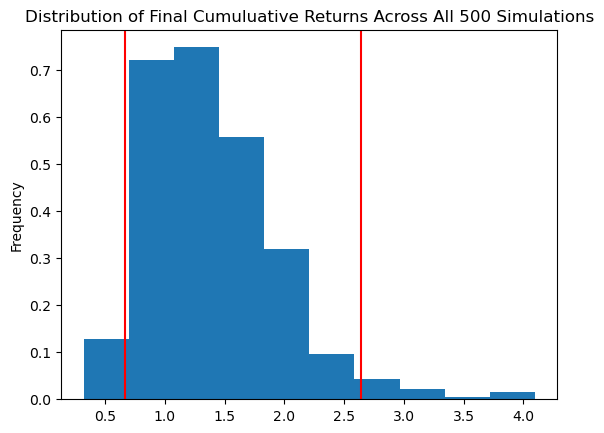

In [38]:
# Plot probability distribution and confidence intervals
dist_plot = MC_3.plot_distribution()

In [41]:
# Fetch summary statistics from the Monte Carlo simulation results
even_table = MC_3.summarize_cumulative_return()
# Print summary statistics
even_table

count           500.000000
mean              1.401602
std               0.538477
min               0.323454
25%               1.004368
50%               1.345251
75%               1.661157
max               4.097143
95% CI Lower      0.663690
95% CI Upper      2.641048
Name: 1260, dtype: float64

In [44]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
lower_range = round(even_table[8]*15000,2)
upper_range = round(even_table[9]*15000,2)

# Print results
print(lower_range)
print(upper_range)

print(f"there is 95% chance that your investment would be between {lower_range} and {upper_range}")

9955.35
39615.71
there is 95% chance that your investment would be between 9955.35 and 39615.71


### Simulate five year portfolio growth with 60% AT&T stock

In [45]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att = MCSimulation(
    portfolio_data= df_ticker,
    weights=[.6,.2,.2],
    num_simulation=1000,
    num_trading_days=252*5
)
# Print the simulation input data
MC_att.portfolio_data.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.68  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.14  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.41  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.08  38.71  38.03  38.56  21829853       82070   

                                                     NKE         ...  \
                                vwap daily_return   open   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  55.43  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.12  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  55.17  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.68  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  54.41  54.50  ...   

                                                     XOM                  \
                                vwap daily_return   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  81.51  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.14  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  82.29  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  81.63  82.2350  81.61   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  

[5 rows x 24 columns]

In [46]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993705,1.007269,1.005109,1.010659,1.013663,0.991478,1.018826,0.981273,1.002744,0.976071,...,1.002168,0.985979,0.990686,1.005244,0.982370,0.987945,0.992618,0.998933,1.008114,0.994688
2,0.984112,0.993628,0.993087,1.015870,1.028419,1.000808,1.020348,0.983257,1.002744,0.986166,...,0.997075,0.980534,0.985539,1.003276,0.978678,0.996128,0.995504,1.007650,1.007492,0.989143
3,0.964780,1.016019,1.012791,1.041647,1.018984,0.994090,1.013961,0.985589,0.978333,0.951885,...,0.998701,0.971457,0.988183,0.980017,0.974377,0.989421,1.006010,1.018600,1.021020,0.992401
4,0.966787,1.033200,1.011824,1.056549,1.035788,1.007528,1.011261,0.974682,0.976816,0.953664,...,1.006685,0.965697,0.989474,0.970358,0.964202,0.987053,1.015820,1.021037,1.014547,0.998942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.507174,1.567744,1.241753,1.815419,1.398812,1.270446,0.900102,1.187758,1.061874,1.340217,...,1.761406,0.606851,2.749605,0.597411,1.663425,0.869529,1.030226,1.669380,0.776864,1.354183
1257,0.493527,1.578207,1.224968,1.824680,1.406034,1.268255,0.898414,1.191824,1.066673,1.349683,...,1.762924,0.607225,2.763335,0.595190,1.653466,0.872144,1.027695,1.659846,0.762752,1.351320
1258,0.498321,1.574296,1.195172,1.810371,1.413800,1.261960,0.890164,1.177944,1.059684,1.331897,...,1.773532,0.605840,2.812818,0.603149,1.674719,0.877760,1.048054,1.661180,0.754222,1.370720
1259,0.496580,1.569010,1.197161,1.819122,1.440962,1.264982,0.880958,1.163944,1.047398,1.340707,...,1.791757,0.606209,2.753101,0.607757,1.661594,0.862277,1.056726,1.657657,0.732361,1.378837


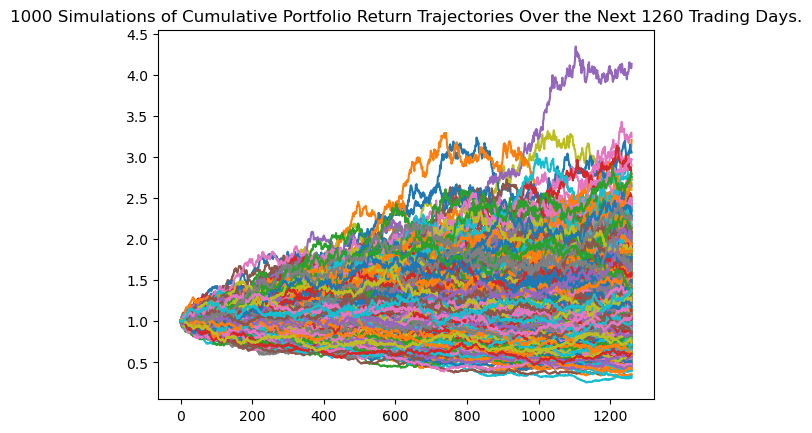

In [47]:
# Plot simulation outcomes
MC_att_plot = MC_att.plot_simulation()

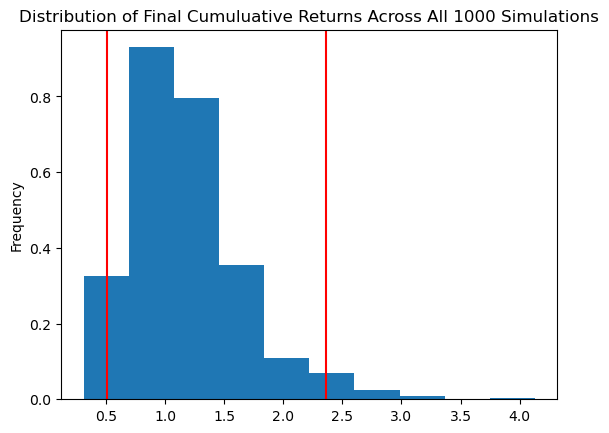

In [48]:
# Plot probability distribution and confidence intervals
att_dist = MC_att.plot_distribution()

In [50]:
# Fetch summary statistics from the Monte Carlo simulation results
att_stats = MC_att.summarize_cumulative_return()
# Print summary statistics
att_stats

count           1000.000000
mean               1.170232
std                0.471729
min                0.311201
25%                0.834339
50%                1.093222
75%                1.400924
max                4.129617
95% CI Lower       0.504851
95% CI Upper       2.358172
Name: 1260, dtype: float64

In [51]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
att_lower_range = round(even_table[8]*15000,2)
att_upper_range = round(even_table[9]*15000,2)

# Print results
print(att_lower_range)
print(att_upper_range)

print(f"there is 95% chance that your investment would be between {att_lower_range} and {att_upper_range}")
# Print results
# YOUR CODE HERE!

9955.35
39615.71
there is 95% chance that your investment would be between 9955.35 and 39615.71


### Simulate five year portfolio growth with 60% Nike stock

In [ ]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
# YOUR CODE HERE!

# Printing the simulation input data
MC_nike.portfolio_data.head()

In [ ]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
# YOUR CODE HERE!

# Print results
# YOUR CODE HERE!

### Simulate five year portfolio growth with 60% Exxon stock

In [ ]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
# YOUR CODE HERE!

# Printing the simulation input data
MC_exxon.portfolio_data

In [ ]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
# YOUR CODE HERE!

# Print results
# YOUR CODE HERE!

### Summarize findings across all 4 simulations

YOUR ANSWER HERE!